In [1]:
import sys
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from filer3 import Filer
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

sys.path.append("../src/")

from vae import LinearVAE

In [2]:
class Trainer(object):

    def __init__(self, net_params, optim_params):
        self.model = LinearVAE(**net_params)
        self.optimizer = optim.Adam(self.model.parameters(), **optim_params)
        self.criterion = nn.BCELoss(reduction='sum')
    
    def train(self, train_datasets, val_datasets, num_epoch, batch_size, save_epoch=None, save_file_path="../models/model_{}.torch"):
        # dataloaderのセット
        train_loader = DataLoader(
            train_datasets,
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = DataLoader(
            val_datasets,
            batch_size=batch_size,
            shuffle=False
        )
        
        # 学習
        losses = []
        for epoch in range(num_epoch):
            train_loss = self.fit(train_loader)
            val_loss = self.validate(val_loader)
        
            losses.append((train_loss, val_loss))
        
            print(
                "[{}][epoch{}] train loss: {}, valid loss {}".format(
                    datetime.datetime.now(), epoch+1, train_loss, val_loss
                )
            )
            
            if save_epoch:
                if epoch % save_epoch == 0 and  epoch != 0:
                    torch.save(self.model.state_dict(), save_file_path.format(epoch))
        return losses
    
    def fit(self, dataloader):
        self.model.train()
        running_loss = 0.0
    
        for i, data in enumerate(dataloader):
            data = data.view(data.size(0), -1)
            self.optimizer.zero_grad()
            reconstruction, mu, logvar = self.model.forward(data)
            bce_loss = self.criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            loss.backward()
            self.optimizer.step()
        train_loss = running_loss/len(dataloader.dataset)

        return train_loss

    def validate(self, dataloader):
        self.model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(dataloader):
                data = data.view(data.size(0), -1)
                reconstruction, mu, logvar = self.model.forward(data)
                bce_loss = self.criterion(reconstruction, data)
                loss = final_loss(bce_loss, mu, logvar)
                running_loss += loss.item()

        val_loss = running_loss/len(dataloader.dataset)
        return val_loss


def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [3]:
# データの読み込み
datasets = Filer.read_pkl("../data/processed/processed_data.pkl")
train_datasets = datasets[:6000]
val_datasets = datasets[6000:]

In [ ]:
num_epoch = 1000
batch_size = 128
net_params = {
    "in_features": 5625,
    "second_features": 1024,
    "latent_features": 256
}
optim_params = {
    "lr": 0.0001
}

trainer = Trainer(net_params, optim_params)

losses = trainer.train(train_datasets, val_datasets, num_epoch, batch_size, save_epoch=10)

[2021-02-23 22:00:49.210212][epoch1] train loss: 2576.0262057291666, valid loss 1849.0387306949806
[2021-02-23 22:00:58.459231][epoch2] train loss: 1835.09175, valid loss 1716.9505786478442
[2021-02-23 22:01:07.822319][epoch3] train loss: 1698.6221796875, valid loss 1609.3499147864381
[2021-02-23 22:01:17.139384][epoch4] train loss: 1636.9539140625, valid loss 1583.1554783019626
[2021-02-23 22:01:26.624061][epoch5] train loss: 1611.7877005208334, valid loss 1554.811239392294
[2021-02-23 22:01:35.822646][epoch6] train loss: 1580.197890625, valid loss 1508.7498680320946
[2021-02-23 22:01:45.018642][epoch7] train loss: 1529.7354322916667, valid loss 1462.679757882883
[2021-02-23 22:01:54.298066][epoch8] train loss: 1497.4839973958333, valid loss 1446.6309272442086
[2021-02-23 22:02:03.732742][epoch9] train loss: 1482.0663723958332, valid loss 1432.1507689329956
[2021-02-23 22:02:13.320016][epoch10] train loss: 1464.9723125, valid loss 1415.232785100949
[2021-02-23 22:02:23.162753][epoch11

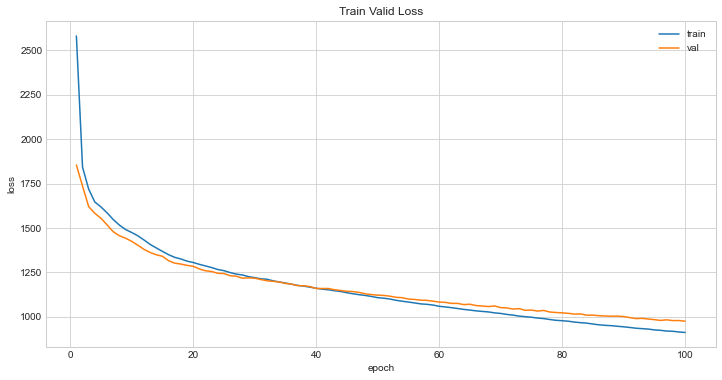

In [10]:
train_loss = [loss[0] for loss in losses]
val_loss = [loss[1] for loss in losses]
epochs = list(range(1, len(losses)+1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label="train")
plt.plot(epochs, val_loss, label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train Valid Loss")
plt.show()